In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from src.utils.dataset import ProstateCancerDataset, GraphDataset
from src.utils.metrics import quadratic_weighted_kappa
from src.utils.helper import collate, evaluate
from src.models.graph_transformer import Classifier

Image.MAX_IMAGE_PIXELS = None

In [2]:
root_dir = '/projectnb/ec500kb/projects/Project_1_Team_1/PANDA'

## Evaluate Model on Test Dataset

In [5]:
test_imgs_dir = root_dir + '/data/test_images'
test_graphs_dir = root_dir + '/data/test_graphs/simclr_files'
test_csv_dir = root_dir + '/data/test.csv'

# Load test dataset.
ids_test, labels_test = ProstateCancerDataset(test_imgs_dir, test_csv_dir).get_data()
dataset_test = GraphDataset(test_graphs_dir, ids_test, labels_test)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=32, num_workers=10,
                             collate_fn=collate, shuffle=True, pin_memory=True, drop_last=True)
total_test_num = len(dataloader_test) * dataloader_test.batch_size

/projectnb/ec500kb/projects/Project_1_Team_1/PANDA/data/test_graphs/simclr_files/39f36065811dabb953b5fa41f826f669/features.pt does not exist.
/projectnb/ec500kb/projects/Project_1_Team_1/PANDA/data/test_graphs/simclr_files/39f36065811dabb953b5fa41f826f669/adj_s.pt does not exist.


In [532]:
# Load saved model.
saved_model_path = root_dir + '/saved_models/200epoch_32batch_0.001lr_0.01decay_0.1gamma.pth'

model = Classifier(n_class=6)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [533]:
# Evaluate on test dataset.
model.eval()

total = 0
scores = 0.0

with torch.no_grad():
    total = 0.
    for i, batch in enumerate(dataloader_test):
        ids = batch['id']
        preds, labels, _ = evaluate(batch, model, False)
        total += len(labels)
        score = quadratic_weighted_kappa(labels, preds, n_class=6)
        scores += score
avg_score = scores/len(dataloader_test)

In [534]:
print('Batch avg score: {:.4f}'.format(avg_score))

Batch avg score: 0.4446


## Visualize Results

Loading and displaying images:   0%|          | 0/4 [00:00<?, ?it/s]

Loading and displaying images: 100%|██████████| 4/4 [02:19<00:00, 34.81s/it]


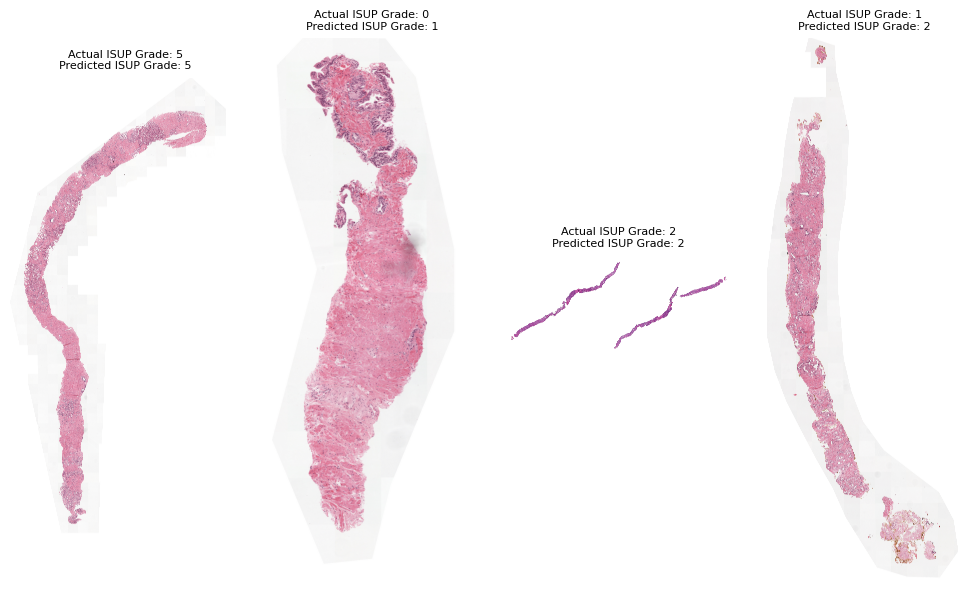

In [12]:
test_img_paths = []
fig, axes = plt.subplots(1, 4, figsize=(10, 6))
axes = axes.flatten()

for i in range(4):
    test_img_path = os.path.join(test_imgs_dir, ids[i] + '.tiff')
    test_img_paths.append(test_img_path)
    
for i, ax in tqdm(enumerate(axes), total=len(axes)):
    if i < len(test_img_paths):
        test_img_path = test_img_paths[i]
        test_img = Image.open(test_img_path)
        ax.imshow(test_img)
        ax.set_title(f'Actual ISUP Grade: {labels[i]}\nPredicted ISUP Grade: {preds[i]}', fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()